# Supervised sentiment: Overview of the Stanford Sentiment Treebank

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Spring 2018 term"

## Contents

0. [Overview of this unit](#Overview-of-this-unit)
0. [Paths through the material](#Paths-through-the-material)
0. [Overview of this notebook](#Overview-of-this-notebook)
0. [The complexity of sentiment analysis](#The-complexity-of-sentiment-analysis)
0. [Set-up](#Set-up)
0. [Data readers](#Data-readers)
  0. [Main readers](#Main-readers)
  0. [All-nodes readers](#All-nodes-readers)
  0. [Methodological notes](#Methodological-notes)
0. [Modeling the SST labels](#Modeling-the-SST-labels)
  0. [Train label distributions](#Train-label-distributions)
  0. [Dev label distributions](#Dev-label-distributions)
0. [Additional sentiment resources](#Additional-sentiment-resources)

## Overview of this unit

We have a few inter-related goals for this unit:

* Provide a basic introduction to supervised learning in the context of a problem that has long been central to academic research and industry applications: __sentiment analysis__.

* Explore and evaluate a diverse array of methods for modeling sentiment:
  * Hand-built feature functions with (mostly linear) classifiers
  * Dense feature representations derived from VSMs as we built them in the previous unit
  * Recurrent neural networks (RNNs)
  * Tree-structured neural networks
  
* Begin discussing and implementing responsible methods for __hyperparameter optimization__ and __classifier assessment and comparison__.

The unit is built around the [Stanford Sentiment Treebank (SST)](http://nlp.stanford.edu/sentiment/), a widely-used resource for evaluating supervised NLU models, and one that provides rich linguistic representations.

## Paths through the material

* If you're relatively new to supervised learning, we suggest studying the details of this notebook closely and following the links to [additional resources](#Additional-sentiment-resources). 

* If you're familiar with supervised learning, then you can focus right away on innovative feature representations and modeling. 

* As of this writing, the state-of-the-art for the SST seems to be around 88% accuracy for the binary problem and 48% accuracy for the five-class problem. Perhaps you can best these numbers!

## Overview of this notebook

This is the first notebook in this unit. It does two things:

* Introduces sentiment analysis as a task.
* Introduces the SST and our tools for reading that corpus.    

## The complexity of sentiment analysis

Sentiment analysis seems simple at first but turns out to exhibit all of the complexity of full natural language understanding. To see this, consider how your intuitions about the sentiment of the following sentences can change depending on perspective, social relationships, tone of voice, and other aspects of the context of utterance:

1. There was an earthquake in LA.
1. The team failed the physical challenge. (We win/lose!)
1. They said it would be great. They were right/wrong.
1. Many consider the masterpiece bewildering, boring, slow-moving or annoying.
1. The party fat-cats are sipping their expensive, imported wines.
1. Oh, you're terrible!

SST mostly steers around these challenges by including only focused, evaluative texts (sentences from movie reviews), but you should have them in mind if you consider new domains and applications for the ideas.

## Set-up

*  Make sure your environment includes all the requirements for [the cs224u repository](https://github.com/cgpotts/cs224u).

* Download [the train/dev/test Stanford Sentiment Treebank distribution](http://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip), unzip it, and put the resulting folder in the same directory as this notebook. It will be called `trees`.

* Make sure you still have the `vsmdata` directory and its contents. ([Here's a link in case you need to redownload it.](http://web.stanford.edu/class/cs224u/data/vsmdata.zip)) In addition, you might want [the Wikipedia 2014 + Gigaword 5 distribution of the pretrained GloVe vectors](http://nlp.stanford.edu/data/glove.6B.zip). This might already be in `vsmdata`, depending on what kind of work you did as part of the VSM unit.

In [2]:
from nltk.tree import Tree
import pandas as pd
import sst

## Data readers

* The train/dev/test SST distribution contains files that are lists of trees where the part-of-speech tags have been replaced with sentiment scores `0...4`:
  * `0` and `1` are negative labels.
  * `2` is a neutral label.
  * `3` and `4` are positive labels. 

* Our readers are iterators that yield `(tree, label)` pairs, where `tree` is an [NLTK Tree](http://www.nltk.org/_modules/nltk/tree.html) instance and `score` is a string.

### Main readers

We'll mainly work with `sst.train_reader` and `sst.dev_reader`.

In [3]:
tree, score = next(sst.train_reader())

Here, `score` is one of the labels. `tree` is an NLTK Tree instance. It should render pretty legibly in your browser:

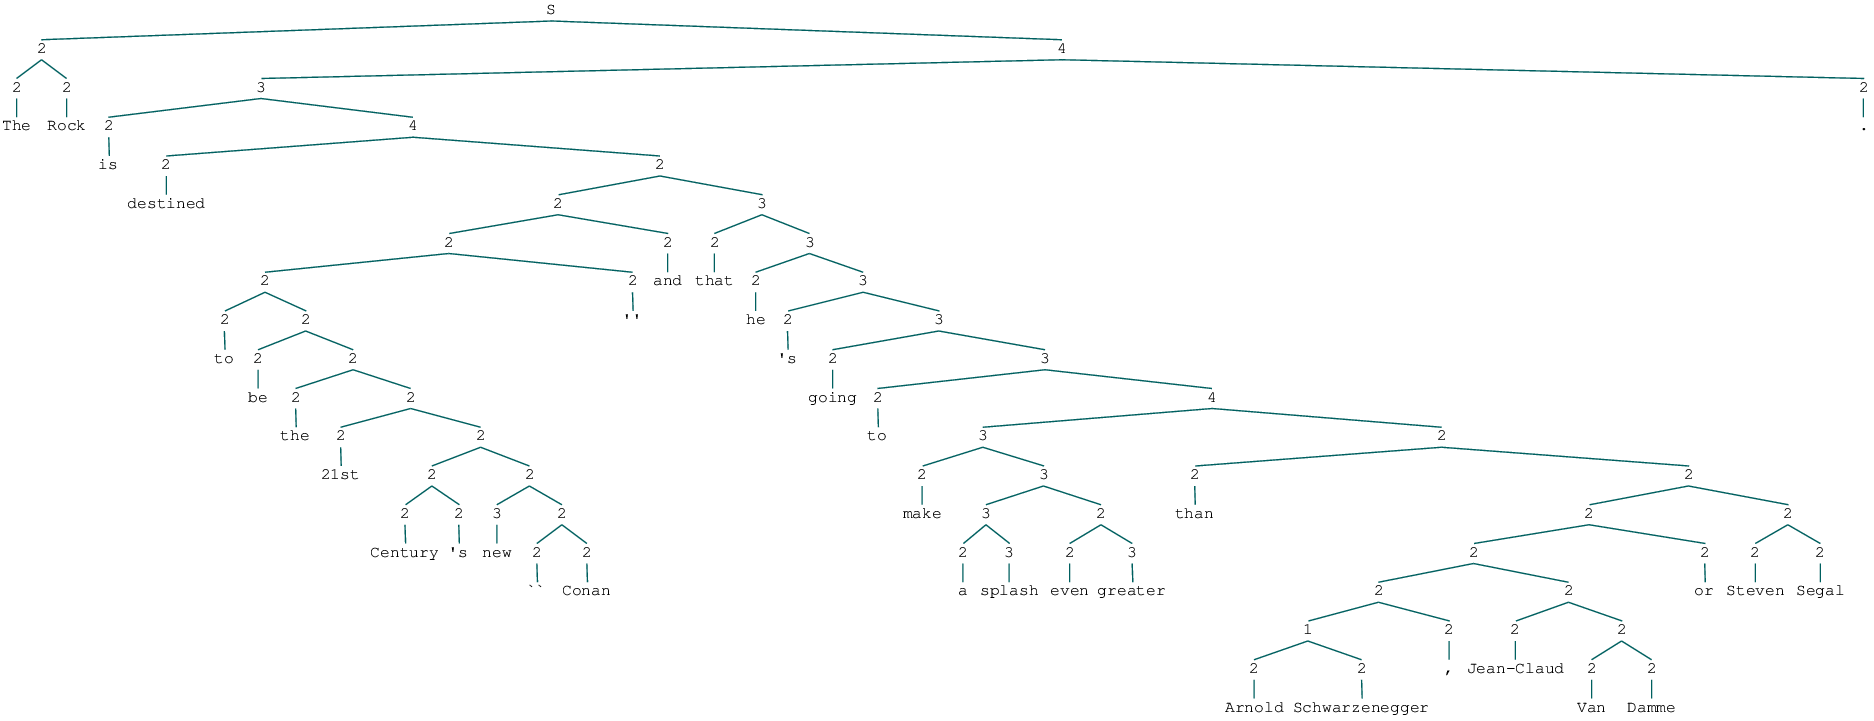

In [4]:
tree

This is what it actually looks like, of course:

In [5]:
(tree,)

(Tree('S', [Tree('2', [Tree('2', ['The']), Tree('2', ['Rock'])]), Tree('4', [Tree('3', [Tree('2', ['is']), Tree('4', [Tree('2', ['destined']), Tree('2', [Tree('2', [Tree('2', [Tree('2', [Tree('2', ['to']), Tree('2', [Tree('2', ['be']), Tree('2', [Tree('2', ['the']), Tree('2', [Tree('2', ['21st']), Tree('2', [Tree('2', [Tree('2', ['Century']), Tree('2', ["'s"])]), Tree('2', [Tree('3', ['new']), Tree('2', [Tree('2', ['``']), Tree('2', ['Conan'])])])])])])])]), Tree('2', ["''"])]), Tree('2', ['and'])]), Tree('3', [Tree('2', ['that']), Tree('3', [Tree('2', ['he']), Tree('3', [Tree('2', ["'s"]), Tree('3', [Tree('2', ['going']), Tree('3', [Tree('2', ['to']), Tree('4', [Tree('3', [Tree('2', ['make']), Tree('3', [Tree('3', [Tree('2', ['a']), Tree('3', ['splash'])]), Tree('2', [Tree('2', ['even']), Tree('3', ['greater'])])])]), Tree('2', [Tree('2', ['than']), Tree('2', [Tree('2', [Tree('2', [Tree('2', [Tree('1', [Tree('2', ['Arnold']), Tree('2', ['Schwarzenegger'])]), Tree('2', [','])]), Tree('

Here's a smaller example:

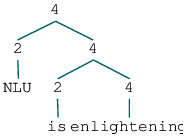

In [6]:
Tree.fromstring("""(4 (2 NLU) (4 (2 is) (4 enlightening)))""")

### All-nodes readers

In SST parlance, the __all-nodes task__ trains and assesses, not just with the full sentence, but also with all the labeled subtrees. We won't explore this task here, but it's good to know about it, and these readers will give you access to this version of the dataset:
  * `sst.allnodes_train_reader`
  * `sst.allnodes_dev_reader`

### Methodological notes

* We've deliberately ignored `test` readers. We urge you not to use the `test` set until and unless you are running experiments for a final project or similar. Overuse of test-sets corrupts them, since even subtle lessons learned from those runs can be incorporated back into model-building efforts.

* We actually have mixed feelings about the overuse of `dev` that might result from working with these notebooks! We've tried to encourage using just splits of the training data for assessment most of the time, with only occasionally use of `dev`. This will give you a clearer picture of how you will ultimately do on `test`; over-use of `dev` can lead to over-fitting on that particular dataset with a resulting loss of performance of `test`.

## Modeling the SST labels

Working with the SST involves making decisions about how to handle the raw SST labels. The interpretation of these labels is as follows ([Socher et al., sec. 3](http://www.aclweb.org/anthology/D/D13/D13-1170.pdf)):

* `'0'`: very negative
* `'1'`: negative
* `'2'`: neutral
* `'3'`: positive
* `'4'`: very positive

The labels look like they could be treated as totally ordered, even continuous. However, conceptually, they do not form such an order. Rather, they consist of three separate classes, with the negative and positive classes being totally ordered in opposite directions:

* `'0' > '1'`: negative
* `'2'`: neutral
* `'4' > '3'`: positive

Thus, in this notebook, we'll look mainly at binary (positive/negative) and ternary tasks.

A related note: the above shows that the __fine-grained sentiment task__ for the SST is particularly punishing as usually formulated, since it ignores the partial-order structure in the categories completely. As a result, mistaking `'0'` for `'1'` is as bad as mistaking `'0'` for `'4'`, though the first error is clearly less severe than the second.

The functions `sst.binary_class_func` and `sst.ternary_class_func` will convert the labels for you, and recommended usage is to use them as the `class_func` keyword argument to `train_reader` and `dev_reader`; examples below.

### Train label distributions

Check that these numbers all match those reported in [Socher et al. 2013, sec 5.1](http://www.aclweb.org/anthology/D/D13/D13-1170.pdf).

In [7]:
train_labels = [y for tree, y in sst.train_reader()]

In [8]:
print("Total train examples: {:,}".format(len(train_labels)))

Total train examples: 8,544


Distribution over the full label set:

In [9]:
pd.Series(train_labels).value_counts()

3    2322
1    2218
2    1624
4    1288
0    1092
dtype: int64

Binary label conversion:

In [10]:
binary_train_labels = [
    y for tree, y in sst.train_reader(class_func=sst.binary_class_func)]

In [11]:
print("Total binary train examples: {:,}".format(len(binary_train_labels)))

Total binary train examples: 6,920


In [12]:
pd.Series(binary_train_labels).value_counts()

positive    3610
negative    3310
dtype: int64

Ternary label conversion:

In [13]:
ternary_train_labels = [
    y for tree, y in sst.train_reader(class_func=sst.ternary_class_func)]

pd.Series(ternary_train_labels).value_counts()

positive    3610
negative    3310
neutral     1624
dtype: int64

### Dev label distributions

Check that these numbers all match those reported in [Socher et al. 2013, sec 5.1](http://www.aclweb.org/anthology/D/D13/D13-1170.pdf).

In [14]:
dev_labels = [y for tree, y in sst.dev_reader()]

In [15]:
print("Total dev examples: {:,}".format(len(dev_labels)))

Total dev examples: 1,101


In [16]:
pd.Series(dev_labels).value_counts()

1    289
3    279
2    229
4    165
0    139
dtype: int64

Binary label conversion:

In [17]:
binary_dev_labels = [
    y for tree, y in sst.dev_reader(class_func=sst.binary_class_func)]

In [18]:
print("Total binary dev examples: {:,}".format(len(binary_dev_labels)))

Total binary dev examples: 872


In [19]:
pd.Series(binary_dev_labels).value_counts()

positive    444
negative    428
dtype: int64

Ternary label conversion:

In [20]:
ternary_dev_labels = [
    y for tree, y in sst.dev_reader(class_func=sst.ternary_class_func)]

pd.Series(ternary_dev_labels).value_counts()

positive    444
negative    428
neutral     229
dtype: int64

## Additional sentiment resources

Here are a few publicly available datasets and other resources; if you decide to work on sentiment analysis, get in touch with the teaching staff — we have a number of other resources that we can point you to.

* Sentiment lexica: http://sentiment.christopherpotts.net/lexicons.html
* NLTK now has a SentiWordNet module: http://www.nltk.org/api/nltk.corpus.reader.html#module-nltk.corpus.reader.sentiwordnet
* Stanford Large Movie Review Dataset: http://ai.stanford.edu/~amaas/data/sentiment/index.html
* SemEval-2013: Sentiment Analysis in Twitter: https://www.cs.york.ac.uk/semeval-2013/task2/
* Starter code for a sentiment-aware tokenizer: http://sentiment.christopherpotts.net/code-data/happyfuntokenizing.py